In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from yolo_opencv import get_objects

In [2]:
objs = get_objects('MVIMG_20191030_130004.jpg', config="yolov3.cfg",
                weights="yolov3.weights",
                classes_="yolov3.txt")
image = None
for obj in objs:
    if obj[0] == 'car':
        image = obj[1]

In [3]:
def apply_threshold_to_img(img, threshold_type="binary"):
    if threshold_type == "binary":
        _,img = cv2.threshold(img,150, 255,cv2.THRESH_BINARY)
    elif threshold_type == "adaptive_gaussian":
        img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    return img

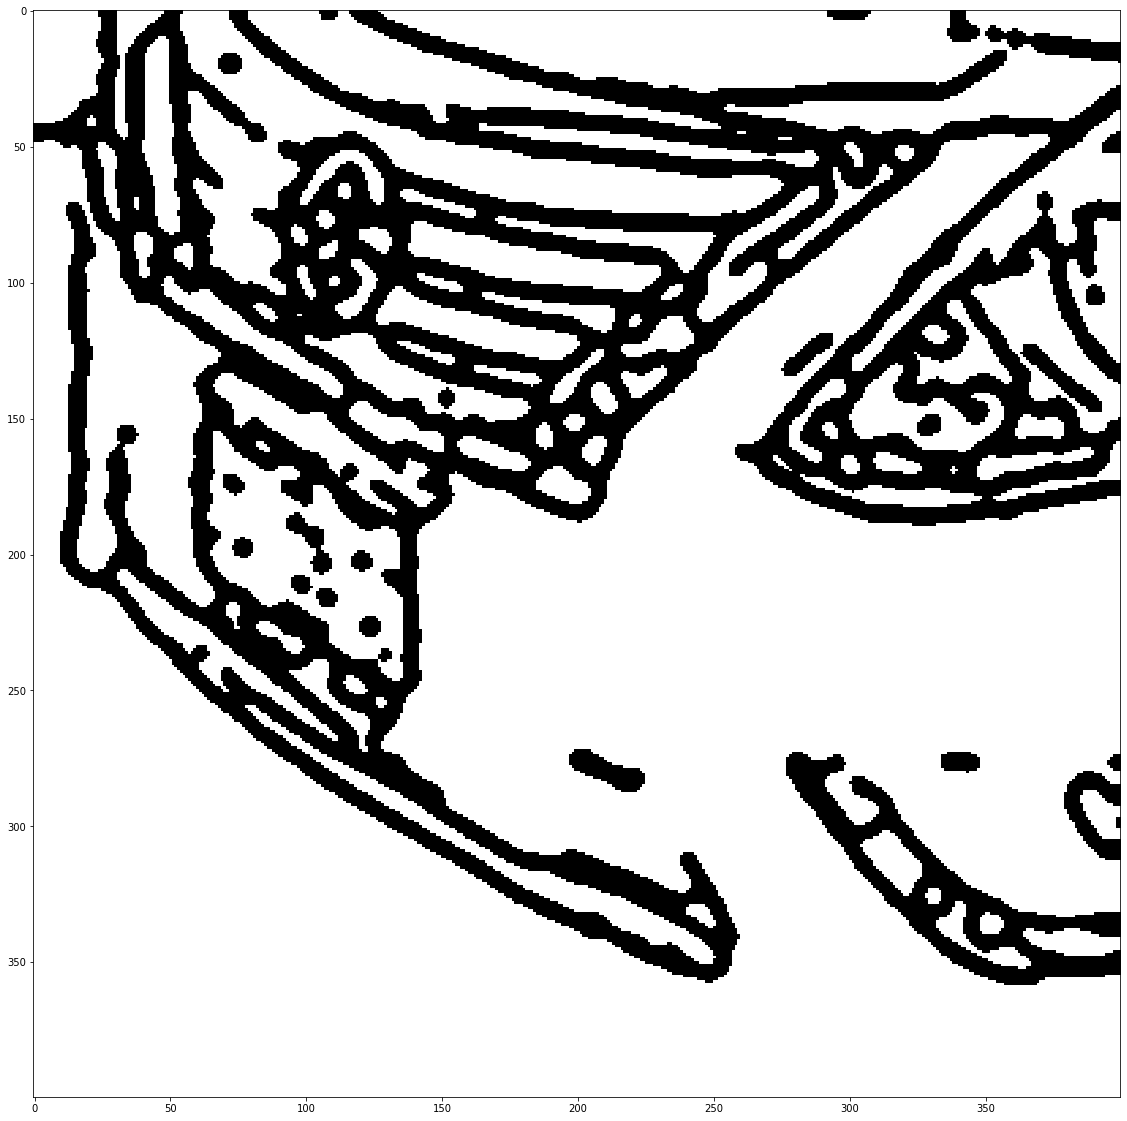

In [4]:
gray = image

aspect_ratio = 1#gray.shape[0] / gray.shape[1]
new_size = 800
gray = cv2.cvtColor(cv2.resize(gray, (int(new_size * aspect_ratio), int(new_size * (1/aspect_ratio)))),
                               cv2.COLOR_BGR2GRAY) #convert to grey scale
gray = gray[int(gray.shape[1]/2):, :int(gray.shape[0]/2)]
gray_orig = gray

gray = cv2.bilateralFilter(gray, 30, 30, 30)
#gray = cv2.medianBlur(gray,5)
#gray = cv2.medianBlur(gray,5)
#gray = cv2.dilate(gray, kernel, iterations=1)

gray = apply_threshold_to_img(gray, "adaptive_gaussian")

gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
gray = apply_threshold_to_img(gray, "binary")

kernel = np.ones((2,2), np.uint8)
gray = cv2.dilate(gray, kernel, iterations=1)
#gray = apply_threshold_to_img(gray, "binary")

gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
gray = apply_threshold_to_img(gray, "adaptive_gaussian")

gray = cv2.dilate(gray, kernel, iterations=1)

gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
gray = apply_threshold_to_img(gray, "adaptive_gaussian")

gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
gray = apply_threshold_to_img(gray, "adaptive_gaussian")

gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
gray = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT)
gray = apply_threshold_to_img(gray, "binary")

fig, ax = plt.subplots(figsize=(int(20*(1*aspect_ratio)), int(20*(1/aspect_ratio))))
ax.imshow(gray, cmap='gray')

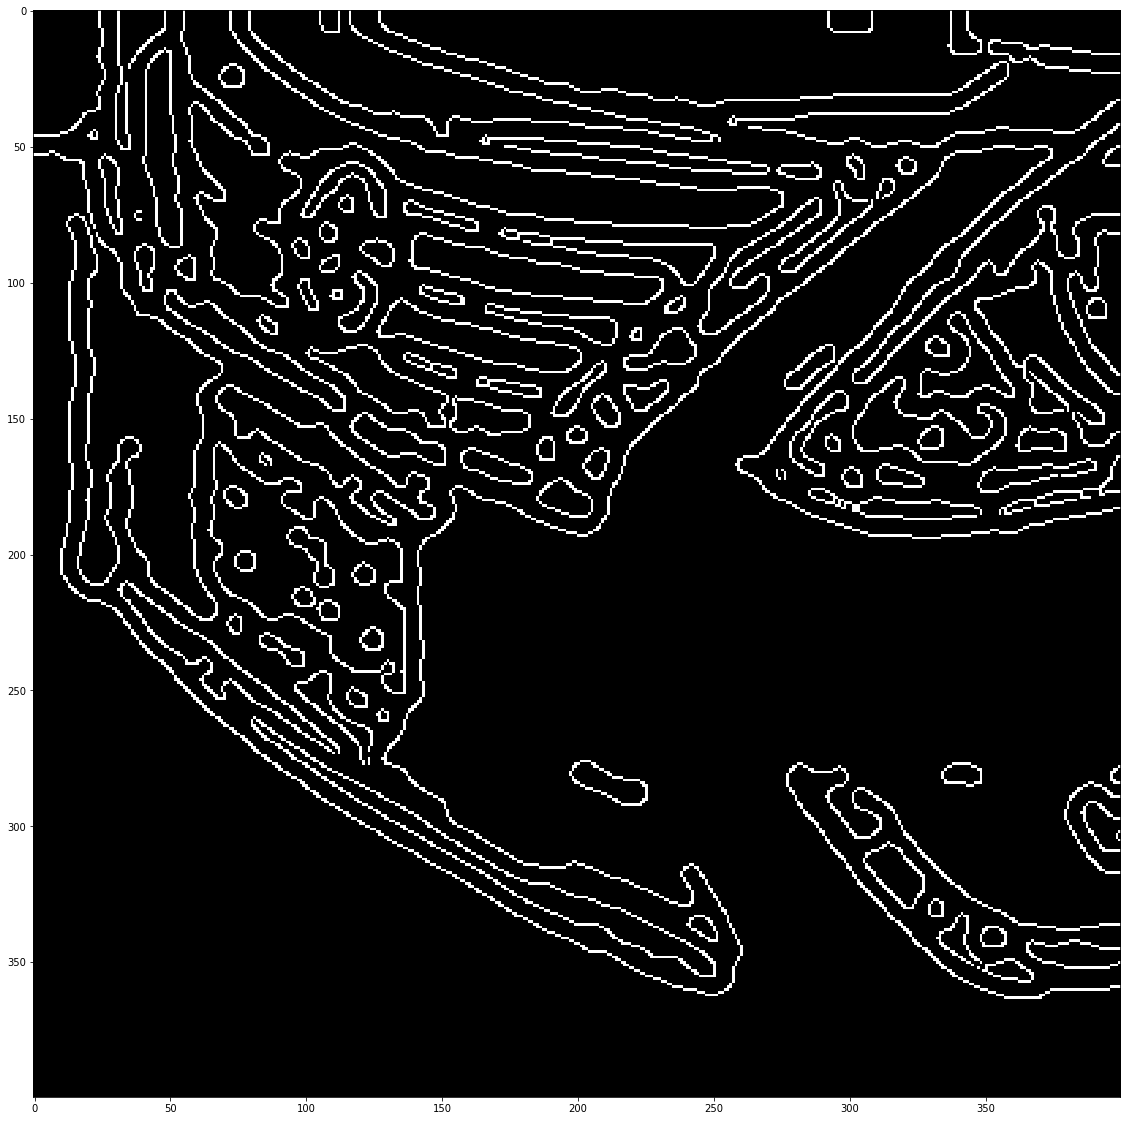

In [5]:
high_thresh, thresh_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lowThresh = 0.5*high_thresh

edged = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

edged = cv2.Canny(edged, lowThresh, high_thresh) #Perform Edge detection

edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, (10,10))
edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, (10,10))
edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, (10,10))
edged = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, (10,10))

fig, ax = plt.subplots(figsize=(30, 20))
ax.imshow(edged, cmap='gray')

In [6]:
_, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

biggest_area = 0
best_candidate = None

best_candidate = None
best_ratio = 0

candidates = []

i = 0
for c in contours:
    c = cv2.convexHull(c, False)
    epsilon = 0.018*cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)
    if len(approx) == 4:
        rect = cv2.minAreaRect(approx)
        box = cv2.boxPoints(rect)
        box = np.int0(approx)
        candidates.append((cv2.contourArea(approx), box))
        i = i + 1

candidates.sort(reverse=True)
candidates = [c[1] for c in candidates[:2]]

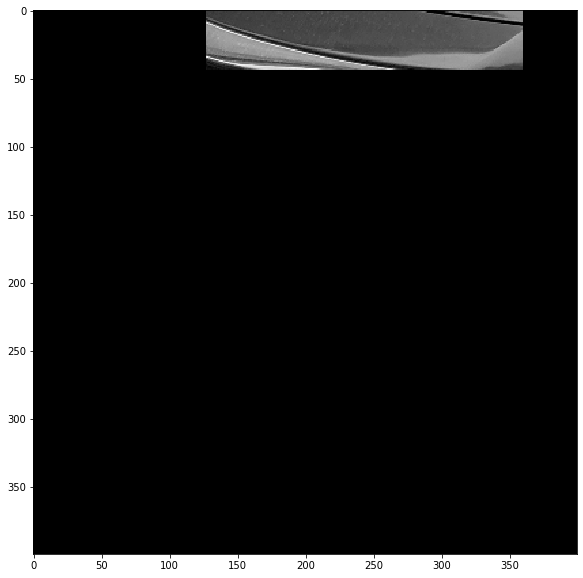

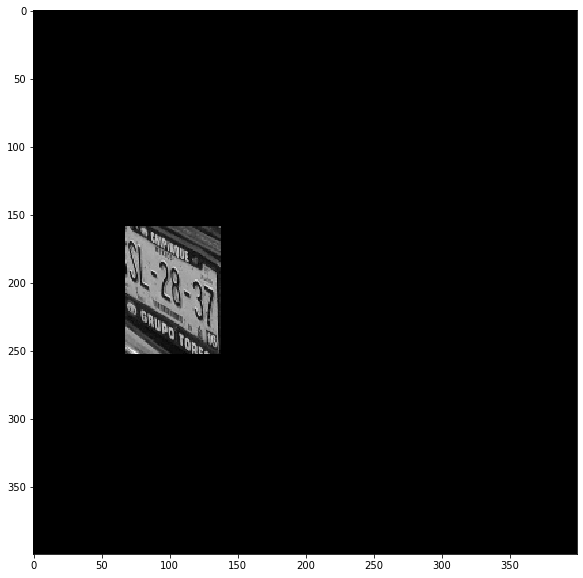

In [7]:
import numpy as np


for i, c in enumerate(candidates):
    contour_mask = np.zeros(gray.shape,np.uint8)
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(contour_mask, (x, y), (x+w, y+h), (255, 255, 255), -1);
    #cv2.drawContours(contour_mask, [c], -1, (255, 255, 255), -1)

    img1_bg = cv2.bitwise_and(gray_orig,gray_orig,mask = contour_mask)

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img1_bg, cmap="gray")
    
    (x, y) = np.where(contour_mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    cropped_img_gray = gray_orig[topx:bottomx+1, topy:bottomy+1]

    cropped_img_gray = cv2.resize(cropped_img_gray, (500, 300))
    
    cv2.imwrite("cropped_img_gray" + str(i) + ".png", cropped_img_gray)